In [30]:
import os, sys

import glob

import iris
import seaborn

import pandas

import warnings
warnings.filterwarnings('ignore')

from iris.experimental.equalise_cubes import equalise_attributes

cwd = os.getcwd()
repo_dir = '/'
for directory in cwd.split('/')[1:]:
    repo_dir = os.path.join(repo_dir, directory)
    if directory == 'ocean-analysis':
        break

modules_dir = os.path.join(repo_dir, 'modules')
sys.path.append(modules_dir)
try:
    import general_io as gio
except ImportError:
    raise ImportError('Must run this script from anywhere within the ocean-analysis git repo')

In [26]:
%matplotlib inline

In [31]:
time_constraints = {'historical-rcp85': gio.get_time_constraint(['1861-01-01', '2100-12-31']),
                    'historicalGHG': gio.get_time_constraint(['1861-01-01', '2005-12-31']),
                    '1pctCO2': gio.get_time_constraint(['1861-01-01', '2000-12-31'])}

In [27]:
def calc_anomaly(cube):
    """Calculate the anomaly."""
    
    anomaly = cube.copy()
    anomaly.data = anomaly.data - anomaly.data[0]
    
    return anomaly


def equalise_time_axes(cube_list):
    """Make all the time axes the same."""

    iris.util.unify_time_units(cube_list)
    reference_cube = cube_list[0]
    new_cube_list = iris.cube.CubeList([])
    for cube in cube_list:
        assert len(cube.coord('time').points) == len(reference_cube.coord('time').points)
        cube.coord('time').points = reference_cube.coord('time').points
        cube.coord('time').bounds = reference_cube.coord('time').bounds
        cube.coord('time').units = reference_cube.coord('time').units
        cube.coord('time').attributes = reference_cube.coord('time').attributes
        new_cube_list.append(cube)
    
    return new_cube_list


def ensemble_aggregation(cube_list, operator):
    """Calculate the ensemble statistic."""

    aggregators = {'mean': iris.analysis.MEAN, 'median': iris.analysis.MEDIAN}

    if len(cube_list) > 1:
        equalise_attributes(cube_list)
        equalise_time_axes(cube_list)
        ensemble_cube = cube_list.merge_cube()
        ensemble_agg = ensemble_cube.collapsed('ensemble_member', aggregators[operator])
    else:
        ensemble_agg = cube_list[0]

    return ensemble_agg



In [45]:
models = ['CanESM2', 'CCSM4', 'CSIRO-Mk3-6-0', 'GISS-E2-R', 'NorESM1-M']
experiments = ['historical-rcp85', 'historicalGHG', '1pctCO2']

In [46]:
data_dir = '/g/data/r87/dbi599/DRSv2/CMIP5'
data_list = []
for experiment in experiments:
    expdir = 'rcp85' if experiment == 'historical-rcp85' else experiment
    tdetails = 'all-wrt-1861' if experiment == '1pctCO2' else 'all'
    time_constraint = time_constraints[experiment]
    rndt_cube_list = iris.cube.CubeList([])
    thetao_diff_list = iris.cube.CubeList([])
    for ensemble_number, model in enumerate(models):
        print(experiment, model)
        rndt_file = '%s/%s/%s/yr/atmos/r1i1p1/rndt/latest/dedrifted/rndt-globe-sum_Ayr_%s_%s_r1i1p1_cumsum-%s.nc' %(data_dir, model, expdir, model, experiment, tdetails)
        thetao_sh_file = '%s/%s/%s/yr/ocean/r1i1p1/thetao/latest/dedrifted/thetao-sh-mean_Oyr_%s_%s_r1i1p1_%s.nc' %(data_dir, model, expdir, model, experiment, tdetails)
        thetao_nh_file = '%s/%s/%s/yr/ocean/r1i1p1/thetao/latest/dedrifted/thetao-nh-mean_Oyr_%s_%s_r1i1p1_%s.nc' %(data_dir, model, expdir, model, experiment, tdetails)
        
        rndt_cube = iris.load_cube(rndt_file, time_constraint)
        rndt_anomaly = calc_anomaly(rndt_cube)

        thetao_sh_cube = iris.load_cube(thetao_sh_file, time_constraint)
        thetao_sh_anomaly = calc_anomaly(thetao_sh_cube)
        
        thetao_nh_cube = iris.load_cube(thetao_nh_file, time_constraint)
        thetao_nh_anomaly = calc_anomaly(thetao_nh_cube)
        
        thetao_diff_cube = thetao_sh_cube.copy()
        thetao_diff_cube.data = thetao_nh_anomaly.data - thetao_sh_anomaly.data
        
        new_aux_coord = iris.coords.AuxCoord(ensemble_number, long_name='ensemble_member', units='no_unit')
        rndt_anomaly.add_aux_coord(new_aux_coord)
        rndt_anomaly.cell_methods = ()
        
        thetao_diff_cube.add_aux_coord(new_aux_coord)
        thetao_diff_cube.cell_methods = ()
        
        rndt_cube_list.append(rndt_anomaly)
        thetao_diff_list.append(thetao_diff_cube)
        
    rndt_ens = ensemble_aggregation(rndt_cube_list, 'median')
    thetao_diff_ens = ensemble_aggregation(thetao_diff_list, 'median')
    
    for i in range(0, rndt_ens.shape[0]):
        row_dict = {'experiment': experiment,
                    'netTOA': rndt_ens.data[i],
                    'thetao': thetao_diff_ens.data[i]}
        data_list.append(row_dict)
        
data_df = pandas.DataFrame(data_list) 

historical-rcp85 CanESM2
historical-rcp85 CCSM4
historical-rcp85 CSIRO-Mk3-6-0
historical-rcp85 GISS-E2-R
historical-rcp85 NorESM1-M
historicalGHG CanESM2
historicalGHG CCSM4
historicalGHG CSIRO-Mk3-6-0
historicalGHG GISS-E2-R
historicalGHG NorESM1-M
1pctCO2 CanESM2
1pctCO2 CCSM4
1pctCO2 CSIRO-Mk3-6-0
1pctCO2 GISS-E2-R
1pctCO2 NorESM1-M


In [47]:
data_df

,experiment,netTOA,thetao
0,historical-rcp85,0.000000e+00,0.000000
1,historical-rcp85,-3.242079e+20,0.003204
2,historical-rcp85,1.471200e+21,0.002255
3,historical-rcp85,4.689570e+21,-0.002353
4,historical-rcp85,5.557567e+21,0.010454
5,historical-rcp85,3.134610e+21,0.008549
6,historical-rcp85,1.671545e+21,0.004405
7,historical-rcp85,8.544960e+21,0.004531
8,historical-rcp85,8.517885e+21,0.012507
9,historical-rcp85,9.824070e+21,0.004493


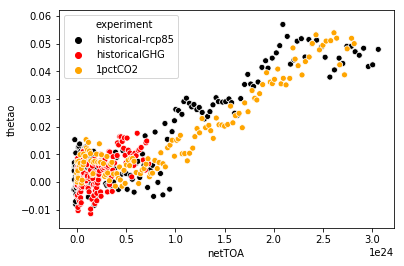

In [49]:
seaborn.scatterplot(x="netTOA", y="thetao", hue="experiment", data=data_df, palette=['black', 'red', 'orange'])

For a sufficiently strong global accumulated netTOA forcing, there is clearly a positive relationship with the interhemispheric ocean temperature difference. (This linear relationship tends to flatten out at high netTOA.)

Perhaps historical-rcp85 tracks slightly higher than 1pctCO2 due to the presence of AAs? (If that's the case it's certainly a secondary influence on the interhemispheric temperature difference.)
